#### **FACES data set**
The FACES dataset consists of 640 black and white face images of people taken with varying pose (straight, left, right, up), expression (neutral, happy, sad, angry), eyes (wearing sunglasses or not), and size.
Each image can be characterized by the pose, expression, eyes, and size. There are 32 images for each person capturing every combination of features.


In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from numpy import argmax
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,PReLU
from keras.initializers import Constant
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical, np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve

In [ ]:
import os
# Create a new folder called "Sunglasses" inside the "Data" folder
sg_folder = os.path.join('Data', 'Sunglasses')
no_sg_folder = os.path.join('Data', 'NoSunglasses')

os.makedirs(sg_folder, exist_ok=True)
os.makedirs(no_sg_folder, exist_ok=True)

In [ ]:
# Loading the data into environment
IMG_WIDTH=32
IMG_HEIGHT=30
IMG_FOLDER=r'Data/'
def create_dataset(img_folder):
  img_data_array=[]
  class_name=[]
  for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
      image_path = os.path.join(img_folder, dir1, file)
      image = cv2.imread( image_path, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
                         interpolation = cv2.INTER_AREA)
      image = np.array(image)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
      class_name.append(dir1)
  return img_data_array, class_name

# Extract the image array and class name
img_data, class_name = create_dataset(IMG_FOLDER)
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}

# Convert the class_names to their respective numeric value based on the dictionary
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

# Convert to X - a 3d array (samples, width, height) and y - 0/1
X = tf.cast(np.array(img_data), tf.float64)
y = tf.cast(list(map(int,target_val)),tf.int32)

#### Splitting into train and test set


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.15, random_state=42)
print('The Dataset size:',len(X.numpy()))
print('Number of images in training set:',len(X_train))
print('Number of images in test set:',len(X_test))
print('Image size is:',X_train[0].shape)

The Dataset size: 624
Number of images in training set: 530
Number of images in test set: 94
Image size is: (32, 30)


#### Plotting

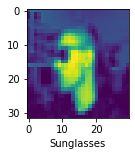

In [ ]:
# Example of an image of the class 'NoSunglasses'
class_names = np.unique(np.array(class_name))  # ['Sunglasses', 'NoSunglasses']

plt.figure(figsize=(5,2))
plt.imshow(X_train[1])
plt.xlabel(class_names[y_train[1]])
plt.show()

Example of an image of the class 'NoSunglasses'


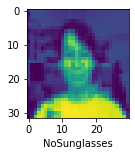

In [ ]:
# Example of an image of the class 'Sunglasses'
plt.figure(figsize=(5,2))
plt.imshow(X_train[55])
plt.xlabel(class_names[y_train[55]])
plt.show()

Example of an image of the class 'Sunglasses'


#### Preprocessing - transforming and scaling the data 




In [ ]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [ ]:
scaler = MinMaxScaler3D()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Search for optimal hyperparameters
We will define the convolutional basis using a stack of Conv2D and MaxPooling2D layers. As input, CNN accepts shape tensors (image_height, image_width, color_channels), where color_channels refers to (R,G,B). We will configure our CNN to process an input of shape (32, 30, 3).

In [ ]:
def cnn(optimizer):
  # Inpute shape (image_height, image_width, color_channels)
  input_shape = X_train[0].shape
  input_shape = (input_shape[0], input_shape[1], 1)

  # Create convolutional base
  model = models.Sequential()
  model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same' ,input_shape=input_shape))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))

  # Add dense layer on top
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

# Compile and train the model
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=cnn, verbose=1)

# The grid search hyperparameters
batch_size = [16, 32, 64]
# learn_rate = [0.001, 0.01, 0.1]
# epochs = [10, 20, 30],
optimizer = ['Adam', 'SGD', 'RMSprop']

param_grid = dict(batch_size=batch_size, epochs=[10, 20, 30], optimizer=optimizer)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=-1,  cv=3)
result = grid_search.fit(X_train, y_train)
print("")
print("The best combination of hyper parameters is: ",grid_search.best_params_, "whose score is: ",grid_search.best_score_)

<ipython-input-14-db017d81518d>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=cnn, verbose=1)


Epoch 1/30
17/17 [==============================] - 1s 38ms/step - loss: 0.7592 - accuracy: 0.5057
Epoch 2/30
17/17 [==============================] - 1s 38ms/step - loss: 0.6649 - accuracy: 0.6453
Epoch 3/30
17/17 [==============================] - 1s 37ms/step - loss: 0.5203 - accuracy: 0.7604
Epoch 4/30
17/17 [==============================] - 1s 37ms/step - loss: 0.3973 - accuracy: 0.8132
Epoch 5/30
17/17 [==============================] - 1s 39ms/step - loss: 0.3342 - accuracy: 0.8509
Epoch 6/30
17/17 [==============================] - 1s 37ms/step - loss: 0.2410 - accuracy: 0.9170
Epoch 7/30
17/17 [==============================] - 1s 36ms/step - loss: 0.1999 - accuracy: 0.9245
Epoch 8/30
17/17 [==============================] - 1s 36ms/step - loss: 0.1903 - accuracy: 0.9340
Epoch 9/30
17/17 [==============================] - 1s 36ms/step - loss: 0.1412 - accuracy: 0.9509
Epoch 10/30
17/17 [==============================] - 1s 37ms/step - loss: 0.1480 - accuracy: 0.9415
Epoch 11/

#### Creating convolutional base

In [ ]:
input_shape = X_train[0].shape
input_shape = (input_shape[0], input_shape[1], 1)

# Create convolutional base
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

#### Display architecture


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

The width and height dimensions tend to shrink as we go deeper in the network. 

#### Adding dense layer on top
To complete our model, we will feed the last output tensor from the convolutional base (of shape (3, 3, 64)) into one or more dense layers to perform classification.

Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor.
First, we will flatten the 3D output to 1D vector.
After that, we will add one or more dense layers on top.

In [ ]:
#Flattening the 3d Variable to 1d
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

#### Compile and train the model

In [ ]:
# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size= grid_search.best_params_['batch_size'],
          epochs= grid_search.best_params_['epochs'],
          validation_data=(X_test,  y_test))

Epoch 1/30
17/17 [==============================] - 1s 48ms/step - loss: 0.6908 - accuracy: 0.5547 - val_loss: 0.6807 - val_accuracy: 0.5851
Epoch 2/30
17/17 [==============================] - 1s 67ms/step - loss: 0.6600 - accuracy: 0.6528 - val_loss: 0.6319 - val_accuracy: 0.6277
Epoch 3/30
17/17 [==============================] - 1s 36ms/step - loss: 0.6078 - accuracy: 0.6811 - val_loss: 0.5530 - val_accuracy: 0.7553
Epoch 4/30
17/17 [==============================] - 0s 29ms/step - loss: 0.5101 - accuracy: 0.7623 - val_loss: 0.4396 - val_accuracy: 0.7979
Epoch 5/30
17/17 [==============================] - 1s 31ms/step - loss: 0.4284 - accuracy: 0.8245 - val_loss: 0.3832 - val_accuracy: 0.8723
Epoch 6/30
17/17 [==============================] - 1s 29ms/step - loss: 0.3600 - accuracy: 0.8547 - val_loss: 0.3286 - val_accuracy: 0.9043
Epoch 7/30
17/17 [==============================] - 1s 31ms/step - loss: 0.3549 - accuracy: 0.8377 - val_loss: 0.2614 - val_accuracy: 0.9149
Epoch 8/30
17

In [ ]:
# we got only two classes - with sunglasses and without sunglasses
def ex_association(model):
  class_preds = []
  MLE_predictions = model.predict(X_test)
  for sample in range(len(MLE_predictions)):
    if MLE_predictions[sample][0] < MLE_predictions[sample][1]:
      class_preds.append(1)
    else:
      class_preds.append(0)
  return class_preds

In [ ]:
# The data distribution
with_glass, without_glass = 0, 0
l = class_name
for i in range(len(class_name)):
  if class_name[i] == "Sunglasses":
    with_glass +=1
  else:
    without_glass +=1
print("The percentage of people with glasses in the data are:" ,round(with_glass/len(class_name),3))
print("The percentage of people without glasses in the data are:" ,round(without_glass/len(class_name),3))

The percentage of people with glasses in the data are: 0.498
The percentage of people without glasses in the data are: 0.502


# Evaluating the model

### Learning Curve

3/3 - 0s - loss: 0.0579 - accuracy: 0.9787 - 37ms/epoch - 12ms/step


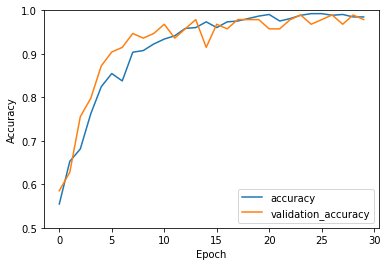

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
y_pred = ex_association(model)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred,target_names=target_names))

3/3 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98        43
     class 1       1.00      0.96      0.98        51

    accuracy                           0.98        94
   macro avg       0.98      0.98      0.98        94
weighted avg       0.98      0.98      0.98        94



### Confusion matrix

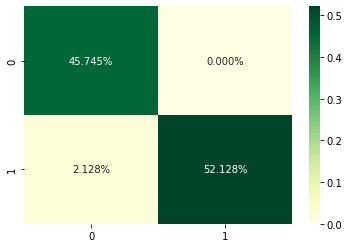

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.3%', cmap='YlGn')

#### ROC Curve

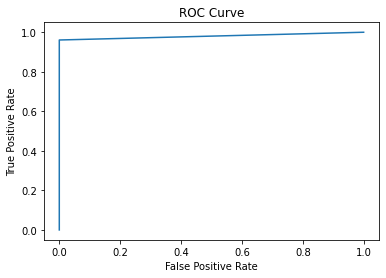

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

######It can be seen that the AUC index gives almost perfect results (converge to 1) under almost completely balanced information, which shows the model's very good learning of the data.

**Question 1: Does the model overfit?**

Answer:Looking at the learning curve graph, it can be seen that our model is not overfit. The training set returns a very high accuracy and it can be thought that the model tends to overfit. However, we can see that the validation set also returns a correspondingly high accuracy. The accuracy of the training set and validation increases in a similar way, while in models that are overfit there is a gap between the accuracy of the training set which is usually high, and accuracy on the validation set which is lower. Therefore, we can conclude that the model will return very good results even on data that it has not yet seen, i.e., the generalization error will be small and therefore the model will not overfit.



**Question 2:**
**What's the effect of batch size? In general, do you see this effect in the current task?**

Answer:
The batch size is a hyperparameter that determines the number of samples to work through before updating the internal model parameters. A larger batch size will typically result in a more stable gradient update, but may also require more run time and memory. However, a smaller batch size may result in a noisy gradient update, but may require less memory and computation power. Thus, there is a trade-off between run time and stability of convergence (in the help of the gradient updates).
In our model, after performing GridSearchCV, we got that the optimal batch size (of the values we tested) is 'batch_size' = 32.

On the other hand, a smaller batch size means that the model will process fewer samples at once, which can lead to slower training times. However, it also means that the model will update its weights more frequently, which can lead to a more accurate model if the batch size is not too small.

In our model, because the batch size is relatively small, you can see that the relatively frequent updating of the weights of our model causes a good job in reducing the loss and therefore, shows high accuracy also on the test set.
It can be said that it shows a general case of low bias low varianve which is excellent from our point of view. It is clear that this is our ambition.

**Question 3: What was the optimal optimizer? Explain.**

Answer:
We performed grid search in order to find the best combination of hyperparameter values that results in the best performance of accuracy. We discovered that the optimal optimizer from the set of possible values is 'RMSprop' optimizer, which the combination of him and 'batch_size' = 32, 'epochs' = 30, yields accuracy score of 0.9754.
one of the most significant benefits of 'RMSprop' optimizer is that studies shows it can help us converge faster than other optimization algorithms while using ANN. Another big benefit of this optimizer is it has adaptive learning rate: RMSprop automatically adjusts the learning rate for each parameter based on the historical gradient information. This can help the model converge faster and avoid getting stuck in local optima.

